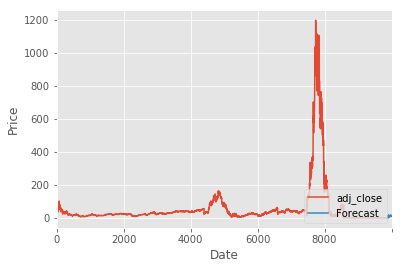

In [17]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime, date, time, timedelta
style.use('ggplot')
import pickle

quandl.ApiConfig.api_key = 'sTWktYRdKfufsd_3NvfG'
df = quandl.get_table('WIKI/PRICES')

df = df [['adj_open','adj_high','adj_low','adj_close','adj_volume']]
df['HL_PCT'] = (df['adj_high'] - df['adj_close']) / df['adj_close'] * 100.0
df['PCT_change'] = (df['adj_close'] - df['adj_open']) / df['adj_open'] * 100.0
df = df [['adj_close','HL_PCT','PCT_change','adj_volume']]

forecast_col = 'adj_close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

## এইখানে pickle use kore amra save kore nitesi ekta tranied classifier...saving and loading from a temporary variable 'poop'.
with open ('linearregression.pickle','wb') as poop:
    pickle.dump(clf, poop)                            #dumping(putting) the classifier in a varibale, poop.
    
## এইখানে we are now using(loading) our saved classifier
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)



confidence = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

# last_date = df.iloc[-1].name
# last_unix = last_date + datetime.datetime.timestamp()
# one_day = 86400
# next_unix = last_unix + one_day

# for i in forecast_set:
#     next_date = datetime.datetime.fromtimestamp(next_unix)
#     next_unix += 86400
#     df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

last_date= df.index.max()
next_unix= last_date + timedelta(days=1).total_seconds()

for i in forecast_set:
    next_date = datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

df['adj_close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()